# GMM learning

In [14]:
import torch
dist = torch.distributions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

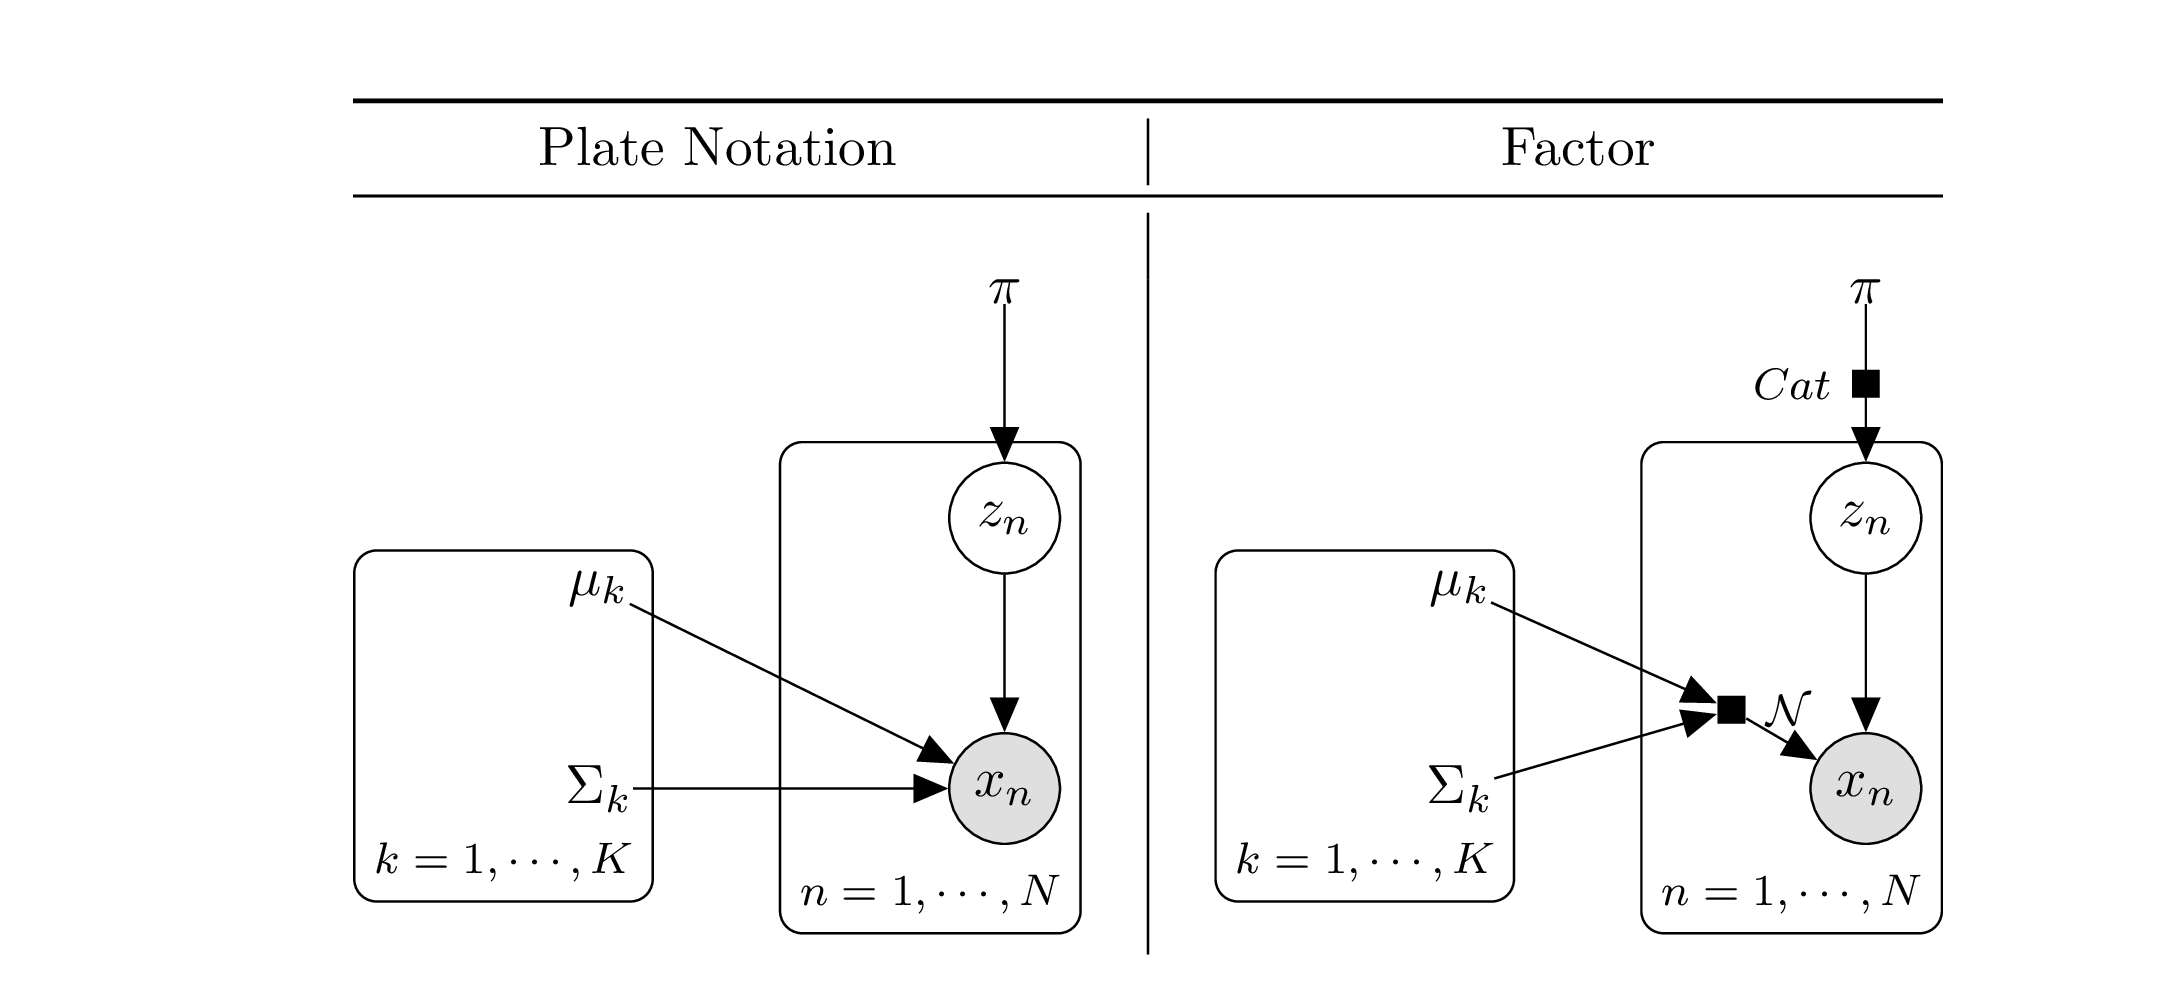

In [13]:
from wand.image import Image as WImage
from wand.color import Color
img = WImage(filename='../pgm/gmm.pdf', resolution=400)
img.crop(500, 600, 2680, 1600)
img

In [15]:
K = 3

mu_1 = -1.
mu_2 = 4.
mu_3 = 10.

sigma_1 = 2.
sigma_2 = 1.
sigma_3 = 1.5

mu = torch.tensor([mu_1, mu_2, mu_3])
sigma = torch.tensor([sigma_1, sigma_2, sigma_3])


dists = dist.Normal(loc = mu, scale = sigma)

In [16]:
pi = torch.tensor([0.5, 0.25, 0.25])
z = dist.Categorical(probs=pi)

In [17]:
N = 1000
samples = {0: [], 1: [], 2: []}
all_samples = []
for n in range(N):
    z_n = z.sample()
    mu_n = mu[z_n]
    sigma_n = sigma[z_n]
    x = dist.Normal(loc = mu_n, scale= sigma_n).sample()
    samples[z_n.item()].append(x.item())
    all_samples.append(x.item())

In [18]:
for k, v in samples.items():
    print(k, len(v))

0 502
1 252
2 246


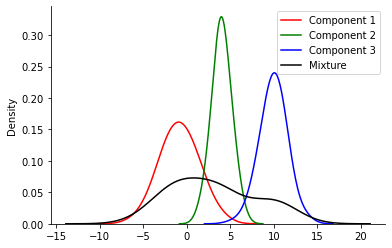

In [19]:
sns.kdeplot(samples[0], bw_adjust=2, color='red', label='Component 1')
sns.kdeplot(samples[1], bw_adjust=2, color='green', label='Component 2')
sns.kdeplot(samples[2], bw_adjust=2, color='blue', label='Component 3')

sns.kdeplot(all_samples, bw_adjust=2, color='black', label='Mixture')
sns.despine()
plt.legend()
#sns.kdeplot(samples_n, bw_adjust=2)

In [20]:
mixture = dist.MixtureSameFamily(mixture_distribution=z, component_distribution=dists)

In [21]:
samples_n = mixture.sample([1000])

In [22]:
mixture.mixture_distribution

Categorical(probs: torch.Size([3]), logits: torch.Size([3]))

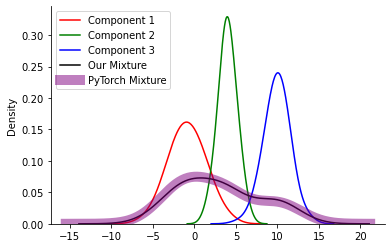

In [29]:
sns.kdeplot(samples[0], bw_adjust=2, color='red', label='Component 1')
sns.kdeplot(samples[1], bw_adjust=2, color='green', label='Component 2')
sns.kdeplot(samples[2], bw_adjust=2, color='blue', label='Component 3')

sns.kdeplot(all_samples, bw_adjust=2, color='black', label='Our Mixture')
sns.despine()
sns.kdeplot(samples_n, bw_adjust=2, color='purple', lw = 10, alpha=0.5, label='PyTorch Mixture')
plt.legend()


In [96]:
to_learn_locs = torch.tensor([0.0, 1.0, 2.0], requires_grad=True)
to_learn_scales = torch.tensor([1.0, 1.0, 1.0], requires_grad=True)
to_learn_scales_softplus = torch.functional.F.softplus(to_learn_scales)
to_learn_dists = dist.Normal(loc=to_learn_locs, scale=to_learn_scales_softplus)

to_learn_mix = torch.tensor([0.3, 0.4, 0.2], requires_grad=True)

to_learn_mixture = dist.Categorical(probs=to_learn_mix)
overall = dist.MixtureSameFamily(
    mixture_distribution=to_learn_mixture, component_distribution=to_learn_dists
)


def nll(loc, scale, mix):
    to_learn_scales_softplus = torch.functional.F.softplus(scale)
    to_learn_dists = dist.Normal(loc=loc, scale=to_learn_scales_softplus)
    mix_softmax = torch.functional.F.softmax(mix)
    to_learn_mixture = dist.Categorical(probs=mix_softmax)
    overall = dist.MixtureSameFamily(
        mixture_distribution=to_learn_mixture, component_distribution=to_learn_dists
    )
    return -torch.sum(overall.log_prob(samples))


opt = torch.optim.Adam([to_learn_locs, to_learn_scales, to_learn_mix], lr=0.05)
for i in range(101):
    loss =nll(to_learn_locs, to_learn_scales, to_learn_mix)
    if i % 10 == 0:
        print(f"Iteration: {i}, Loss: {loss.item():0.2f}")
    loss.backward()
    # loc_array.append(theta_learn_loc)
    # loss_array.append(loss_val.item())

    opt.step()
    opt.zero_grad()

Iteration: 0, Loss: 16368.27
Iteration: 10, Loss: 10628.43
Iteration: 20, Loss: 8328.17
Iteration: 30, Loss: 7339.84
Iteration: 40, Loss: 6849.51
Iteration: 50, Loss: 6566.24
Iteration: 60, Loss: 6376.24
Iteration: 70, Loss: 6226.55
Iteration: 80, Loss: 6086.78
Iteration: 90, Loss: 5958.18
Iteration: 100, Loss: 5888.01


/var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/ipykernel_48017/2345747116.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mix_softmax = torch.functional.F.softmax(mix)


In [97]:
to_learn_locs

tensor([-1.6593,  6.8915,  4.1946], requires_grad=True)

In [100]:
to_learn_scales

tensor([1.4718, 3.8919, 2.9224], requires_grad=True)

In [102]:
s

tensor([0.3407, 0.3356, 0.1757], requires_grad=True)

In [104]:
torch.functional.F.softmax(to_learn_mix)

/var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/ipykernel_48017/1334526509.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.functional.F.softmax(to_learn_mix)


tensor([0.3518, 0.3500, 0.2983], grad_fn=<SoftmaxBackward0>)